<a href="https://colab.research.google.com/github/Alimob78/AI_hackathon/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Assumptions.png to Assumptions.png


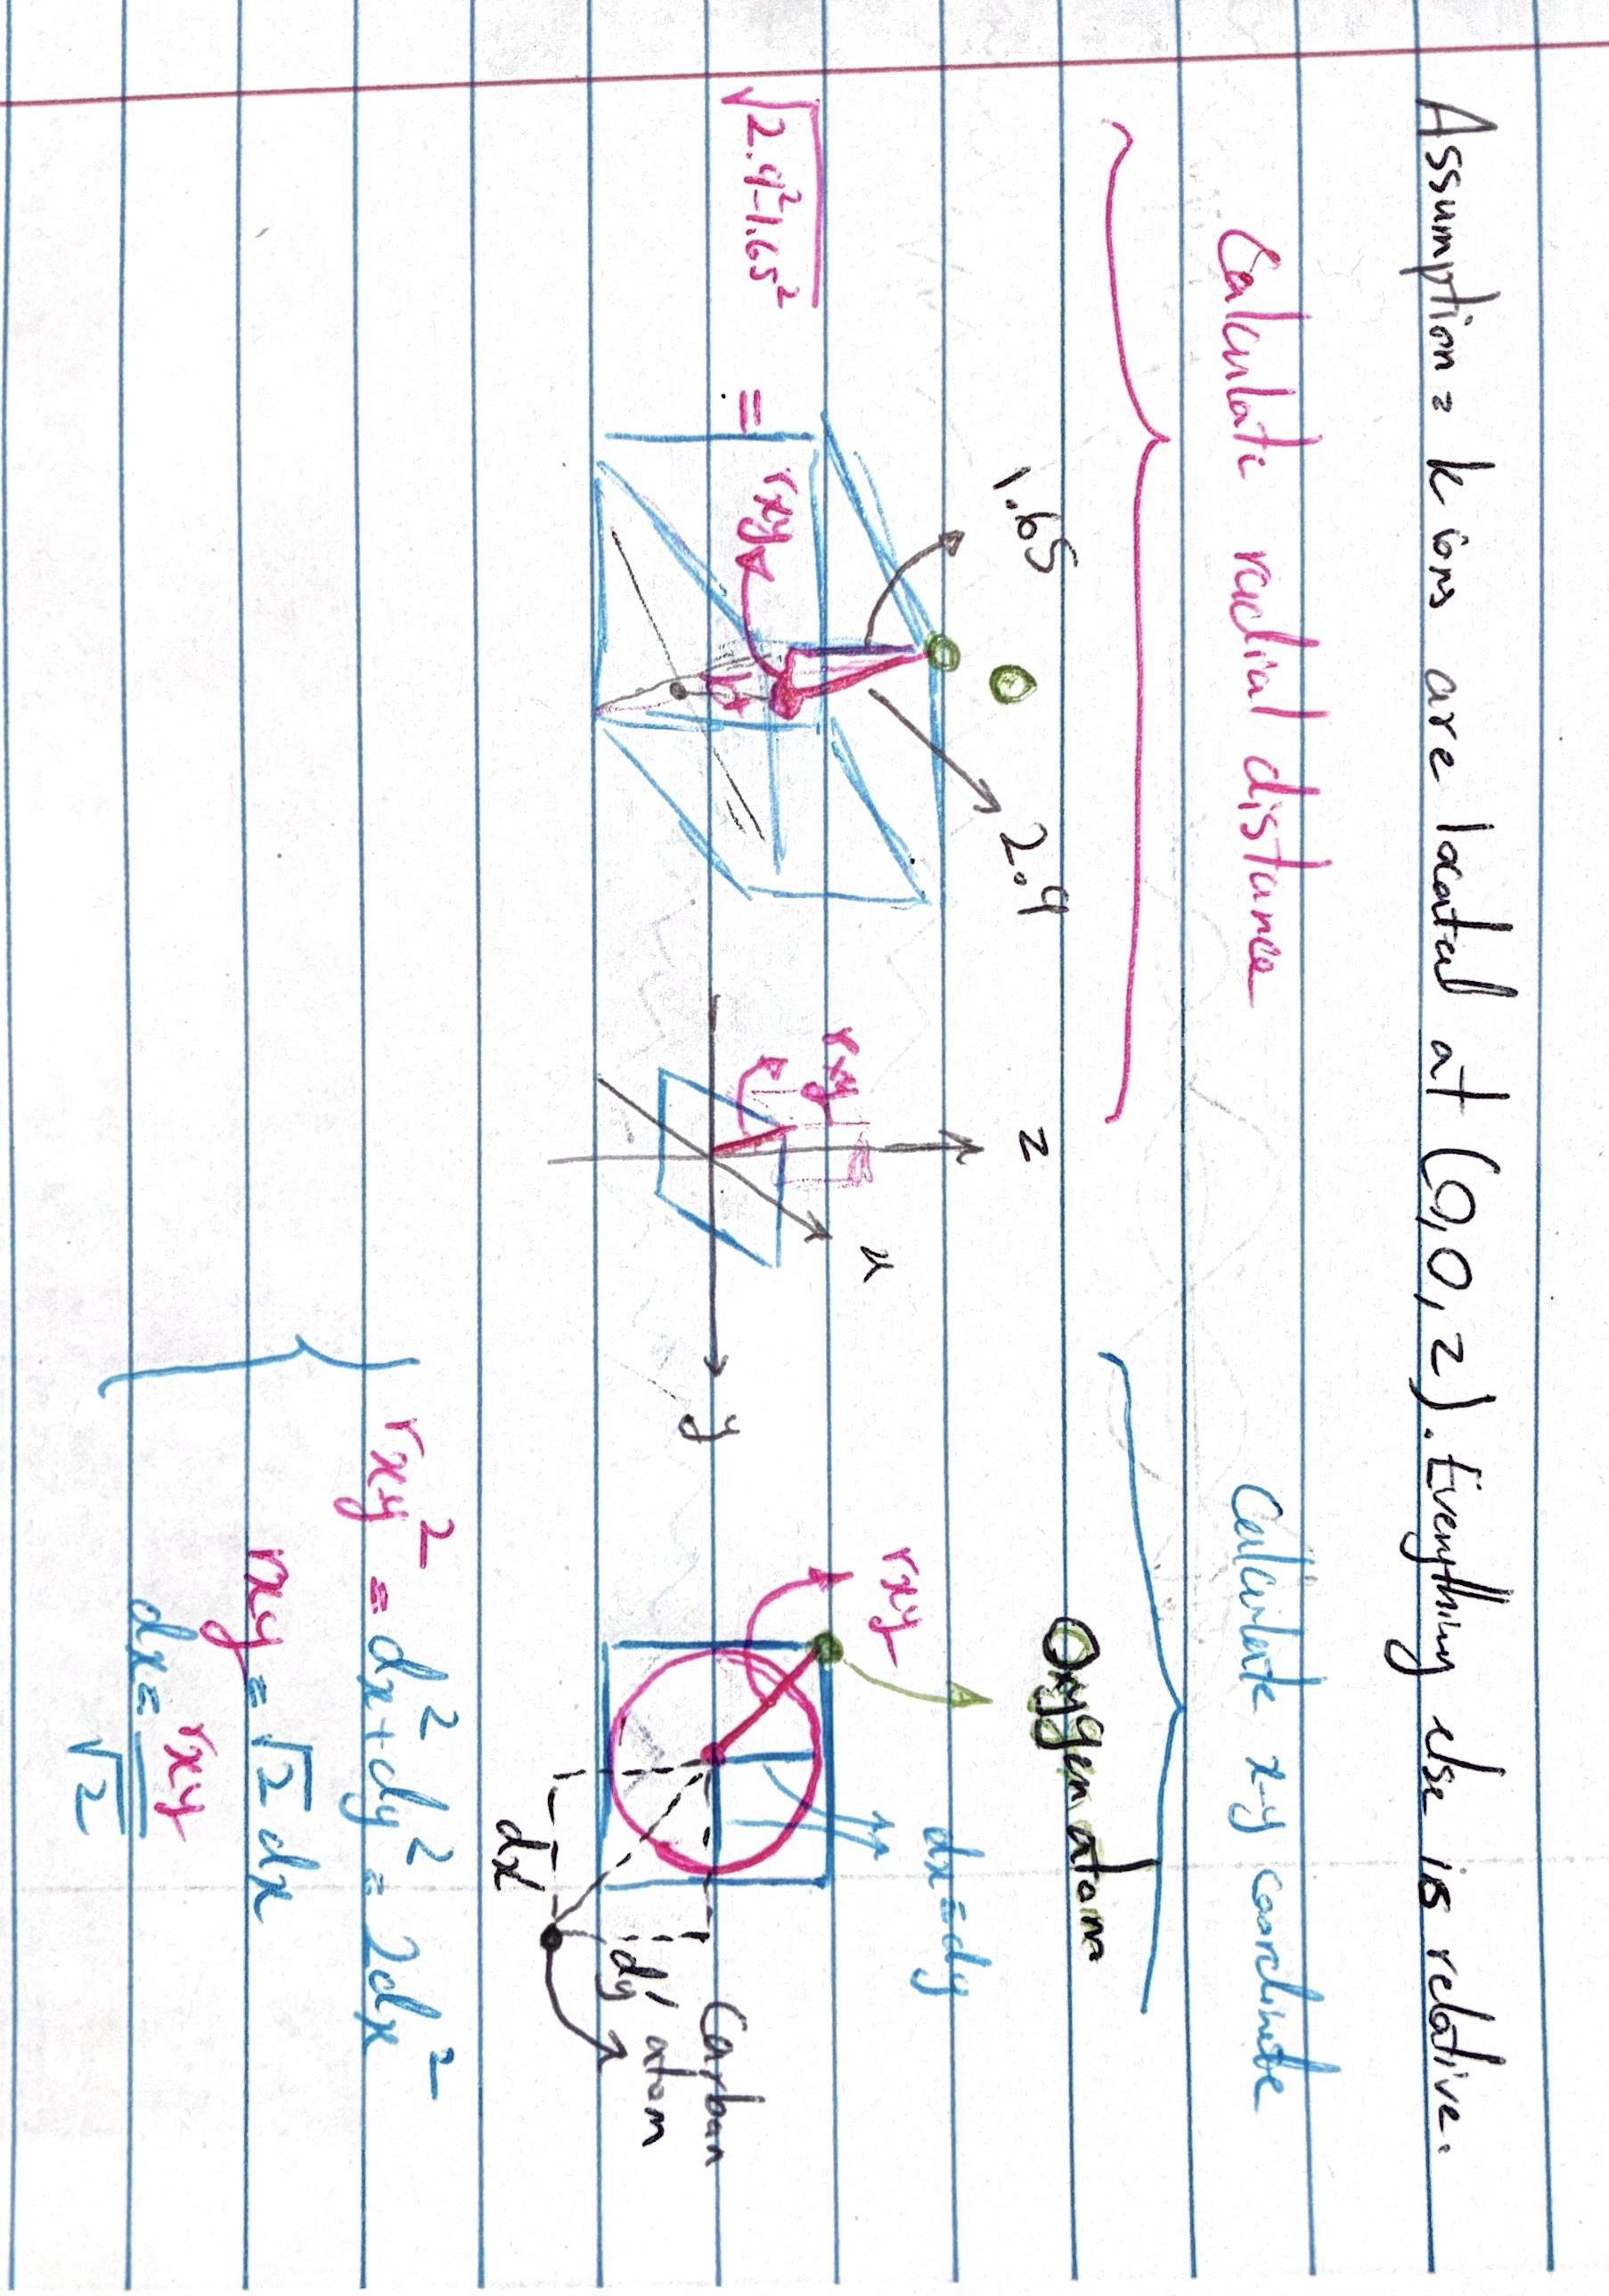

In [38]:
from google.colab import files
uploaded = files.upload()
from IPython.display import Image
Image(list(uploaded.keys())[0])


In [30]:
# lib
import math
import numpy as np


# Constants (formulas)
K_CONST = 560.4
eps = 4.0

# Geometry (Å)
DZ = 3.3          # spacing between planes O or K planes
K_O = 2.9         # full 3D distance K ion –Oxygen
K_C = 3.7         # full 3D distance K ion –Carbon
DZ_OK = 1.65       # z separation between K and O plane

# Assuming K is placed at (0,0,z)
R_OXY = math.sqrt(K_O**2 - DZ_OK**2)  # horizontal radius for oxygens from K
R_CXY = math.sqrt(K_C**2 - DZ_OK**2)  # horizontal radius for carbons from K



def distance(p1, p2):
    """ distance between two 3D points in Å."""
    p1 = np.array(p1, dtype=float)
    p2 = np.array(p2, dtype=float)
    return float(np.linalg.norm(p1 - p2))

def pair_energy(qi, qj, r, eps):
    """Electrostatic interaction energy between two charges in kBT."""
    return K_CONST * qi * qj / (eps * r)

def plane_coordinate_generator(radius, z):
    """
    Return 4 coordinates in the xy plane at distance `radius` from origin (K),
    forming a square around (0,0,z).
    """
    a = radius / math.sqrt(2.0)
    return [
        ( a,  a, z),
        (-a,  a, z),
        (-a, -a, z),
        ( a, -a, z),
    ]


def build_all_atoms():
    """
    Build a dictionary of ALL atoms in the K+ channel model:
      - 4 K+ ions
      - 20 oxygens (5 planes × 4)
      - 20 carbons  (5 planes × 4)
    Coordinates are based on the
    K–O and K–C 3D distances with a z-offset of DZ_OK.
    """

    all_atoms = {}

    # 5 oxygen/carbon planes at z = 0, 3.3, 6.6, 9.9, 13.2 Å
    oxygen_plane_z = [i * DZ for i in range(5)]

    # 4 K+ sites located halfway between O planes:
    # z = 1.65, 4.95, 8.25, 11.55 Å
    k_site_z = [z + DZ_OK for z in oxygen_plane_z[:-1]]

    # ------------------------------------
    # Add K ions: K_S1..K_S4
    # ------------------------------------
    for s, z in enumerate(k_site_z, start=1):
        all_atoms[f"K_S{s}"] = {
            "type": "K",
            "q": +1.0,
            "pos": (0.0, 0.0, z),
        }

    # ------------------------------------
    # Add Oxygens + Carbons for each plane
    # ------------------------------------
    for p, z in enumerate(oxygen_plane_z, start=1):

        # 4 oxygens on this plane
        for k, pos in enumerate(plane_coordinate_generator(R_OXY, z), start=1):
            all_atoms[f"O_P{p}_{k}"] = {
                "type": "O",
                "q": -0.51,
                "pos": pos,
            }

        # 4 carbons on this plane
        for k, pos in enumerate(plane_coordinate_generator(R_CXY, z), start=1):
            all_atoms[f"C_P{p}_{k}"] = {
                "type": "C",
                "q": +0.51,
                "pos": pos,
            }

    return all_atoms


all_atoms = build_all_atoms()
all_atoms

{'K_S1': {'type': 'K', 'q': 1.0, 'pos': (0.0, 0.0, 1.65)},
 'K_S2': {'type': 'K', 'q': 1.0, 'pos': (0.0, 0.0, 4.949999999999999)},
 'K_S3': {'type': 'K', 'q': 1.0, 'pos': (0.0, 0.0, 8.25)},
 'K_S4': {'type': 'K', 'q': 1.0, 'pos': (0.0, 0.0, 11.549999999999999)},
 'O_P1_1': {'type': 'O',
  'q': -0.51,
  'pos': (1.686342195404005, 1.686342195404005, 0.0)},
 'O_P1_2': {'type': 'O',
  'q': -0.51,
  'pos': (-1.686342195404005, 1.686342195404005, 0.0)},
 'O_P1_3': {'type': 'O',
  'q': -0.51,
  'pos': (-1.686342195404005, -1.686342195404005, 0.0)},
 'O_P1_4': {'type': 'O',
  'q': -0.51,
  'pos': (1.686342195404005, -1.686342195404005, 0.0)},
 'C_P1_1': {'type': 'C',
  'q': 0.51,
  'pos': (2.3417408054692985, 2.3417408054692985, 0.0)},
 'C_P1_2': {'type': 'C',
  'q': 0.51,
  'pos': (-2.3417408054692985, 2.3417408054692985, 0.0)},
 'C_P1_3': {'type': 'C',
  'q': 0.51,
  'pos': (-2.3417408054692985, -2.3417408054692985, 0.0)},
 'C_P1_4': {'type': 'C',
  'q': 0.51,
  'pos': (2.3417408054692985, -

In [31]:
################ Q1a: Energy for two configurations

def energy_KO_for_config(config, all_atoms):
    """
    Compute total energy (kBT) for Q1a for a given K occupancy.

    config: list of length 4, e.g. [0,1,0,1] for {0, K, 0, K}; order: [S1, S2, S3, S4]

    Uses:
      - K–K interactions
      - K–O interactions
    Rules:
      - K sites with config = 0 are treated as q = 0 (no ion)
      - O atoms keep q = -0.51
      - C atoms are ignored (effective q = 0 for Q1a)
    """
    # Effective charges after applying configuration
    q_eff = {}

    for name, atom in all_atoms.items():
        t = atom["type"]

        if t == "K":
            # name is "K_S1", "K_S2", etc. Last char is the site index. [-1] gives the index essentially
            site = int(name[-1])              # 1..4
            occ = config[site - 1]            # 0 or 1
            q_eff[name] = occ

        elif t == "O":
            q_eff[name] = atom["q"]           # -0.51

        elif t == "C":
            q_eff[name] = 0.0                 # ignore carbons in Q1a

        else:
            q_eff[name] = 0.0

    # Sum K–K and K–O interactions
    total = 0.0
    names = list(all_atoms.keys())

    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            A = names[i]
            B = names[j]
            atomA = all_atoms[A]
            atomB = all_atoms[B]

            typeA, typeB = atomA["type"], atomB["type"]
            qA, qB = q_eff[A], q_eff[B]

            # Only include pairs where at least one is K
            if not (typeA == "K" or typeB == "K"):
                continue

            r = distance(atomA["pos"], atomB["pos"])
            total += pair_energy(qA, qB, r, eps)

    return total


# Classic configuration: {0, K, 0, K} = S2 and S4 occupied
classic_config = [0, 1, 0, 1]

# Hard-knock configuration: {0, K, K, 0} = S2 and S3 occupied
hard_config = [0, 1, 1, 0]

U_classic = energy_KO_for_config(classic_config, all_atoms)
U_hard    = energy_KO_for_config(hard_config, all_atoms)

print(f"  U(0,K,0,K)  = {U_classic:.3f} kBT")
print(f"  U(0,K,K,0)  = {U_hard:.3f} kBT")
print(f"  ΔU (hard - classic) = {U_hard - U_classic:.3f} kBT")

  U(0,K,0,K)  = -619.827 kBT
  U(0,K,K,0)  = -626.382 kBT
  ΔU (hard - classic) = -6.555 kBT


In [32]:
################ Q1b: two neighboring ions

# Two-ion neighbor configurations
config_S1_S2 = [1, 1, 0, 0]   # K at S1 and S2
config_S2_S3 = [0, 1, 1, 0]   # K at S2 and S3
config_S3_S4 = [0, 0, 1, 1]   # K at S3 and S4

U_S1_S2 = energy_KO_for_config(config_S1_S2, all_atoms)
U_S2_S3 = energy_KO_for_config(config_S2_S3, all_atoms)
U_S3_S4 = energy_KO_for_config(config_S3_S4, all_atoms)

print("\nQ1b: ")
print(f"  U(K,K,0,0)  [S1-S2] = {U_S1_S2:.3f} kBT")
print(f"  U(0,K,K,0)  [S2-S3] = {U_S2_S3:.3f} kBT")
print(f"  U(0,0,K,K)  [S3-S4] = {U_S3_S4:.3f} kBT")


print(f" So [S2-S3] where ions occupy the two middle sites are most favourable")



Q1b: 
  U(K,K,0,0)  [S1-S2] = -598.600 kBT
  U(0,K,K,0)  [S2-S3] = -626.382 kBT
  U(0,0,K,K)  [S3-S4] = -598.600 kBT
 So [S2-S3] where ions occupy the two middle sites are most favourable


In [35]:
################ Q1c: including carbons - jsut add the effective charge of the carbon to the function (+0.51)
def energy_KO_for_config(config, all_atoms):
    """
    Compute total energy (kBT) for Q1a for a given K occupancy.

    config: list of length 4, e.g. [0,1,0,1] for {0, K, 0, K}; order: [S1, S2, S3, S4]

    Uses:
      - K–K interactions
      - K–O interactions
    Rules:
      - K sites with config = 0 are treated as q = 0 (no ion)
      - O atoms keep q = -0.51
      - C atoms are ignored (effective q = 0 for Q1a)
    """
    # Effective charges after applying configuration
    q_eff = {}

    for name, atom in all_atoms.items():
        t = atom["type"]

        if t == "K":
            # name is "K_S1", "K_S2", etc. Last char is the site index. [-1] gives the index essentially
            site = int(name[-1])              # 1..4
            occ = config[site - 1]            # 0 or 1
            q_eff[name] = occ

        elif t == "O":
            q_eff[name] = atom["q"]           # -0.51

        elif t == "C":
            q_eff[name] = 0.51                 # consider carbons in Q1c; +0.51

        else:
            q_eff[name] = 0.0

    # Sum K–K and K–O interactions
    total = 0.0
    names = list(all_atoms.keys())

    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            A = names[i]
            B = names[j]
            atomA = all_atoms[A]
            atomB = all_atoms[B]

            typeA, typeB = atomA["type"], atomB["type"]
            qA, qB = q_eff[A], q_eff[B]

            # Only include pairs where at least one is K
            if not (typeA == "K" or typeB == "K"):
                continue

            r = distance(atomA["pos"], atomB["pos"])
            total += pair_energy(qA, qB, r, eps)

    return total


# Two-ion neighbor configurations
config_S1_S2 = [1, 1, 0, 0]   # K at S1 and S2
config_S2_S3 = [0, 1, 1, 0]   # K at S2 and S3
config_S3_S4 = [0, 0, 1, 1]   # K at S3 and S4

U_S1_S2 = energy_KO_for_config(config_S1_S2, all_atoms)
U_S2_S3 = energy_KO_for_config(config_S2_S3, all_atoms)
U_S3_S4 = energy_KO_for_config(config_S3_S4, all_atoms)

print("\nQ1c: ")
print(f"  U(K,K,0,0)  [S1-S2] = {U_S1_S2:.3f} kBT")
print(f"  U(0,K,K,0)  [S2-S3] = {U_S2_S3:.3f} kBT")
print(f"  U(0,0,K,K)  [S3-S4] = {U_S3_S4:.3f} kBT")


print(f" So still [S2-S3] where ions occupy the two middle sites are most favourable")



Q1c: 
  U(K,K,0,0)  [S1-S2] = -57.572 kBT
  U(0,K,K,0)  [S2-S3] = -61.152 kBT
  U(0,0,K,K)  [S3-S4] = -57.572 kBT
 So still [S2-S3] where ions occupy the two middle sites are most favourable
